# 1D Convolution
Let $a$ and $b$ be arrays with four entries, the convolution of $a$ and $b$ is then an array $c$ with seven entries computed as visualized below: 

<img src="images/conv_1d/gif.gif" />

Formally, the i'th entry of a convolution is given (for now we disregard zero-padding, we added code in the end for completeness that shows how to do zero-padding): 

$$\gamma_l = \sum_{i,j: i+j=l} \alpha_i \beta_j$$

If we compute all $\gamma_l$ by using the above formula we spend a total of $O(n^2)$ time. Quite surprisingly, it turns out that we can compute $\gamma$ b using the discrete fourier transform (DFT):

$$\gamma = \text{DFT}^{-1} (\text{DFT}(x) \odot \text{DFT}(y))$$

Here $\odot$ denotes entrywise multiplication. The DFT can be computed in $O(n\log n)$ time by a <a href="https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-046j-design-and-analysis-of-algorithms-spring-2015/lecture-notes/MIT6_046JS15_lec03.pdf">genious</a> divide an conquer algorithm. The above formula thus yields a way to compute convolutions in $O(n\log n)$ time! This assymptotical speedup is similar to that of <a href="https://en.wikipedia.org/wiki/Insertion_sort">insertion sort</a> compared to <a href="https://en.wikipedia.org/wiki/Merge_sort">merge sort</a>!

Since the DFT is a <a href="https://en.wikipedia.org/wiki/Linear_map">linear transform</a> it is captured by a matrix, the <a href="https://en.wikipedia.org/wiki/DFT_matrix">DFT matrix</a>. Let $\omega$ be the $n$'th <a href="https://en.wikipedia.org/wiki/Root_of_unity">root of unity</a> then the DFT matrix is given

$$
\begin{align}
(F_n)_{ij}=\omega^{i\cdot j}\quad \quad F_n=
\begin{pmatrix}
\omega^0 & \omega^0 & \omega^0 & ... & \omega^0\\
\omega^0 & \omega^1 & \omega^2 & ... & \omega^{(n-1)} \\
\omega^0 & \omega^2 & \omega^4 & ... & \omega^{2(n-1)} \\
\vdots & \vdots & \vdots & & \vdots\\
\omega^0 & \omega^{(n-1)} & \omega^{2(n-1)} & ... & \omega^{(n-1)(n-1)} \\
\end{pmatrix}\in \mathbb{C}^{n \times n}
\end{align}
$$

Notice this is the <a href="https://en.wikipedia.org/wiki/Vandermonde_matrix">Vandermonde</a> matrix with roots of unity. The matrix is clearly symmetric since $(F_n)_{ij}=\omega^{ij}=\omega^{ji}=(F_n^T)_{ij}$. Furthermore, if we scale $F$ by a factor $1/\sqrt{n}$ it holds that $\overline{F^T}=F^{-1}$ (the transform is <a href="https://en.wikipedia.org/wiki/Unitary_matrix">unitary</a>). 

The following argument shows how we can compute convolutions using the fourier transform: 

$$
\begin{align}
(F\alpha \odot F\beta)_i &= \left(\sum_l \alpha_l \omega^{il} \right) \left(\sum_k \beta_k \omega^{ik}\right)\\
&= \sum_m \gamma_m \omega^{im} \quad\text{where}\quad \gamma_m=\sum_{l,k: l+k=m} \alpha_l\beta_k\\
&= F\gamma
\end{align}
$$

Since $F$ has an inverse it holds that $F^{-1}F\gamma=\gamma$. In conclusion we get

$$\gamma = \text{DFT}^{-1} (\text{DFT}(x) \odot \text{DFT}(y))$$

The only property we used of $F$ above is (1) it has an inverse and (2) that $F_{ij}=x^{ij}$ for a some special $x$. Since we didn't use any particular property of $\omega$ the above also works for any $x$ so that (1) is still satisfied. That said, the choice of $\omega$ is important for performing the transform in $O(n\log n)$ time. 

A <a href="">similar argument</a> can be made for the 2d convolution. 

The code below computes convolution naively and with the DFT. Some might think the DFT variant is simpler to implement as the magic happens in just one line of code when we use a library for DFT. 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import dft
from numpy.fft import fft, ifft

a = np.array([1,2,3,4])
b = np.array([5,4,3,2])

def convolution_naive(a, b): 
    assert a.shape == b.shape
    a = np.concatenate((a,          np.zeros(a.shape)))
    b = np.concatenate((np.flip(b), np.zeros(b.shape)))

    n = a.shape[0]
    c = np.zeros(n)
    
    for l in range(c.shape[0]):
        for i in range(l+1):
            c[l] += a[i] * b[l-i]
        
    return c[:n-1]

def convolution_dft(a, b): 
    assert a.shape == b.shape
    
    a = np.concatenate((a,          np.zeros(a.shape)))
    b = np.concatenate((np.flip(b), np.zeros(b.shape)))
    n = a.shape[0]
    
    conv = ifft(fft(a) * fft(b))
    
    return np.real(conv)[:n-1] # numerical errors cause an imaginary part. 

print(convolution_dft(  a,b))
print(convolution_naive(a,b))


[ 2.  7. 16. 30. 34. 31. 20.]
[ 2.  7. 16. 30. 34. 31. 20.]


The code below was used to produce the GIF in the start of this post: 

<IPython.core.display.Javascript object>


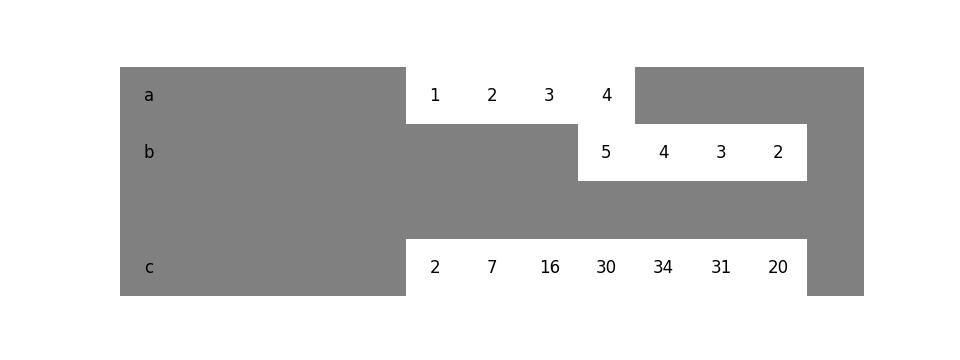

In [81]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

def plot(num):
    ax.cla()
    image = np.zeros((4, 2*n-1+6))
    image[0, 5:9] = a
    image[1, 2+num:6+num] = b
    image[3, 5: 5+num+1] = conv[:num+1]
    
    ax.imshow(image, cmap="gray", vmin=-1, vmax=1)
    
    grid  = np.ndenumerate(image)
    ax.axis('off')
    for (j,i), label in grid: # define grid
        if label != 0.0: ax.text(i,j,int(label),ha='center',va='center')
        
        if i == 0: 
            if j == 0:  ax.text(i,j,"a",ha='center',va='center')
            if j == 1:  ax.text(i,j,"b",ha='center',va='center')
            if j == 3:  ax.text(i,j,"c",ha='center',va='center')
        
    
    #plt.tight_layout()
    plt.pause(.1)
    fig.canvas.draw()
    plt.savefig("images/conv_1d/%i.jpg"%num)
    
    
    #pass # animate a frame, fixate a and move b. 

a = np.array([1,2,3,4])
b = np.array([5,4,3,2])
conv = convolution_dft(a,b)

n = a.shape[0]

fig, ax = plt.subplots(figsize=(8, 3))

for i in range(2*n-1): 
    plot(i)